# My implementation of scDeepCluster with PBMC dataset

This notebook allows the loading of my implementation of scDeepCluster method on the PBMC dataset by splitting the dataset into a train, val and test sets (allowing fine tuning of the model) and save results in the indicated directory

## Import useful modules

In [1]:
!pip install scanpy
!pip install keras
!pip install tensorflow
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip3 install igraph
!pip3 install leidenalg
!pip install os
!pip install csv

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement csv (from versions: none

In [3]:
from keras import layers
from keras.layers import Layer
from keras.models import load_model, Model
from keras import backend as K
from keras.losses import KLDivergence
import numpy as np
import scanpy as sc
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from layers import ConstantDispersionLayer, SliceLayer, ColWiseMultLayer
import keras
from keras.layers import Layer
from sklearn.model_selection import train_test_split
import datetime
import time
import os
import csv
from scipy.optimize import linear_sum_assignment as linear_assignment
import h5py

In [4]:
tf.__version__

'2.16.1'

In [5]:
keras.__version__

'3.3.3'

## Preprocessing

### Load dataset

Import dataset PBMC and check the data

In [6]:
filename="./dataset/10X_PBMC.h5"
with h5py.File(filename, 'r') as f :
    data_X=f['X'][:]
    data_Y=f['Y'][:]
    df_X=pd.DataFrame(data_X)
    df_Y=pd.DataFrame(data_Y)
    
df_X

,0,1,2,3,4,5,6,7,8,9,...,16643,16644,16645,16646,16647,16648,16649,16650,16651,16652
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4267,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,1.0,20.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df_Y.columns=['label']
df_Y["label"]=df_Y['label'].astype(str)
df_Y

,label
0,2
1,2
2,2
3,8
4,3
...,...
4266,6
4267,5
4268,7
4269,3


Create the AnnData

In [8]:
df_Y["label"].value_counts()

label
1    1292
2     702
3     606
4     459
5     450
6     332
7     295
8     135
Name: count, dtype: int64

In [9]:
data_ann=sc.AnnData(df_X)
data_ann

/shared/home/tberthet/.local/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/shared/home/tberthet/.local/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 4271 × 16653

In [10]:
data_ann.obs=df_Y

### Filter data

In [11]:
sc.pp.filter_cells(data_ann, min_genes=1)
sc.pp.filter_genes(data_ann, min_cells=1)

/shared/home/tberthet/.local/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [12]:
#make a copy of the raw matrix before normalizing
data_ann.raw = data_ann.copy()

In [13]:
data_ann

AnnData object with n_obs × n_vars = 4271 × 16653
    obs: 'label', 'n_genes'
    var: 'n_cells'

### Normalize and scale

In [14]:
#normalize
sc.pp.normalize_total(data_ann)

#compute size factors
data_ann.obs['size_factors'] = data_ann.obs.n_genes / np.median(data_ann.obs.n_genes)
#data_ann.obs['size_factors'] = 1.0

#log transform
sc.pp.log1p(data_ann)


Features selection : selection of high variable genes

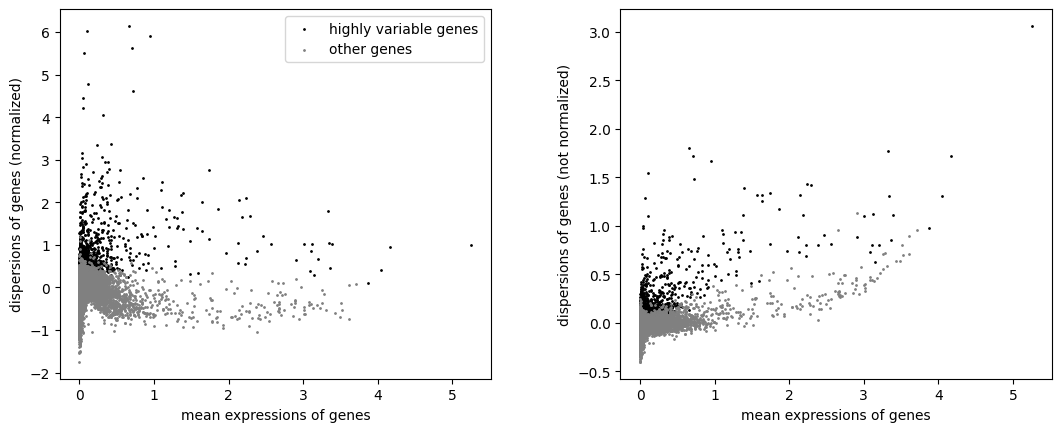

In [15]:
sc.pp.highly_variable_genes(data_ann, n_top_genes=2000, batch_key="label")
sc.pl.highly_variable_genes(data_ann)

In [16]:
# scale the data
sc.pp.scale(data_ann)

### Explore the result

In [17]:
data_ann.X

array([[-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358],
       [-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358],
       [-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358],
       ...,
       [-0.04478425, -0.36973775, -0.22519336, ..., 16.46698363,
        -0.05613264, -0.09001358],
       [-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358],
       [-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358]])

In [18]:
data_ann.n_vars

16653

In [19]:
data_ann.X

array([[-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358],
       [-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358],
       [-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358],
       ...,
       [-0.04478425, -0.36973775, -0.22519336, ..., 16.46698363,
        -0.05613264, -0.09001358],
       [-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358],
       [-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358]])

In [20]:
data_ann.var

,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,mean,std
0,9,False,0.002611,-0.013101,-0.060134,0,False,0.001286,0.028724
1,570,False,0.135255,-0.001270,0.209814,1,False,0.091207,0.246681
2,225,False,0.050292,-0.021517,0.112911,1,False,0.034340,0.152490
3,12,False,0.001860,-0.149268,-0.466780,0,False,0.001729,0.033887
4,106,False,0.024858,0.030561,0.267766,1,False,0.016371,0.106600
...,...,...,...,...,...,...,...,...,...
16648,322,False,0.070651,0.029831,0.317225,2,False,0.050375,0.184955
16649,78,False,0.018880,0.000764,0.153966,2,False,0.011738,0.090542
16650,9,False,0.001481,-0.250185,-1.141559,0,False,0.001020,0.023021
16651,15,False,0.003912,-0.137269,-0.271806,0,False,0.002027,0.036117


In [21]:
data_ann.obs

,label,n_genes,size_factors
0,2,748,0.607636
1,2,1052,0.854590
2,2,739,0.600325
3,8,874,0.709992
4,3,951,0.772543
...,...,...,...
4266,6,1807,1.467912
4267,5,1249,1.014622
4268,7,2223,1.805849
4269,3,983,0.798538


In [22]:
data_ann.raw.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Get only the data corresponding to the high variable genes

In [23]:
# get the preprocessed count matrix of the high variables genes only
highly_variable_genes = data_ann.var[data_ann.var['highly_variable']].index.tolist()
count_data_hvg = data_ann[:, highly_variable_genes].X
count_data_hvg=count_data_hvg.toarray()
count_data_hvg

array([[-0.18050484,  2.43124879, -0.14809046, ...,  1.56127602,
         0.09961133, -0.09001358],
       [-0.18050484, -0.53800062, -0.14809046, ...,  1.69599056,
         1.66225718, -0.09001358],
       [-0.18050484, -0.53800062, -0.14809046, ...,  1.78981483,
         1.59504406, -0.09001358],
       ...,
       [-0.18050484,  1.1276868 , -0.14809046, ...,  0.37132976,
         0.64876498, -0.09001358],
       [-0.18050484,  1.59388979, -0.14809046, ..., -0.255126  ,
        -0.7171908 , -0.09001358],
       [-0.18050484, -0.53800062, -0.14809046, ..., -0.74846542,
         0.85199629, -0.09001358]])

In [24]:
#get the raw matrix of the high variable genes only
raw_count_hvg=data_ann.raw[:,highly_variable_genes].X

## Loss functions

In [24]:
def negative_binomial_loss(y_true, y_pred):
    """
    Compute the Negative Binomial loss (NB loss)
    
    Inputs :
        y_true (numpy array) :  the true labels matrix
        y_pred : the prediction fo the autoencoder resulting of the concatenation of 
                mu layer and theta layer (in this order)
    
    Output : 
        final (float) : the NB loss value
    """
    #get the mu layer and the theta layer from y_pred
    input_shape=int(y_pred.shape[1]/2)
    mu = y_pred[:, :input_shape]
    theta = y_pred[:, input_shape:]
    
    #change y_true data type to a tensor object
    y_true = tf.cast(y_true, dtype='float32')

    #compute the loss
    eps = 1e-10
    t1 = tf.math.lgamma(theta+eps) + tf.math.lgamma(y_true+1.0) - tf.math.lgamma(y_true+theta+eps)
    t2 = (theta+y_true) * tf.math.log(1.0 + (mu/(theta+eps))) + (y_true * (tf.math.log(theta+eps) - tf.math.log(mu+eps)))
    final=t1 + t2
    final = tf.reduce_mean(final)
    return final

def zero_inflated_negative_binomial_loss(y_true, y_pred):
    """
    Compute the Zero Inflated Negative Binomial loss (ZINB loss)
    
    Inputs :
        y_true (numpy array) :  the true labels matrix
        y_pred : the prediction fo the autoencoder resulting of the concatenation of 
                mu layer, pi layer and theta layer (in this order)
    
    Output : 
        result (float) : the ZINB loss value
    """
    #get the mu, pi and theta layer from y_pred
    input_shape=int(y_pred.shape[1]/3)
    mu = y_pred[:, :input_shape]
    pi = y_pred[:, input_shape:input_shape*2]
    theta = y_pred[:, input_shape*2:]
    
    # change the data type of y_true to a tensor object
    y_true = tf.cast(y_true, dtype='float32')

    #compute the ZINB loss
    eps = 1e-10
    t1 = tf.math.lgamma(theta+eps) + tf.math.lgamma(y_true+1.0) - tf.math.lgamma(y_true+theta+eps)
    t2 = (theta+y_true) * tf.math.log(1.0 + (mu/(theta+eps))) + (y_true * (tf.math.log(theta+eps) - tf.math.log(mu+eps)))
    final=t1 + t2
    
    nb_case = t1 + t2 - tf.math.log(1.0-pi+eps)
    zero_nb = tf.pow(theta/(theta+mu+eps), theta)
    zero_case = -tf.math.log(pi + ((1.0-pi)*zero_nb)+eps)
    result = tf.where(tf.less(y_true, 1e-8), zero_case, nb_case)
    #ridge = self.ridge_lambda*tf.square(self.pi)
    #result += ridge
    result = tf.reduce_mean(result)
    return result


## Create autoencoder

In [25]:
#activation function for the mean layer
MeanAct = lambda x: tf.clip_by_value(tf.keras.backend.exp(x), 1e-5, 1e6)

#activation function for the theta layer
DispAct = lambda x: tf.clip_by_value(tf.keras.backend.softplus(x), 1e-4, 1e4)

#custome layer to get the final mu layer taking into accounts the size factors
ColWiseMultLayer = lambda name: layers.Lambda(lambda l: l[0]*(tf.matmul(tf.reshape(l[1], (-1,1)),
                                                                 tf.ones((1, l[0].get_shape()[1]),
                                                                         dtype=l[1].dtype))), name=name)

In [26]:
#create a class for the clustering layer
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters=n_clusters
        self.alpha=alpha
        self.intial_weights=weights
        #self.input_spec=keras.InputSpec(ndim=2) #to specify the expected rank of the input

    #build the clustering layer with the good shape and set weights if any
    def build(self, input_shape):
        input_dim=input_shape[1]
        #self.input_spec=keras.InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform')
        if self.intial_weights is not None :
            self.set_weights(self.intial_weights)
            del self.intial_weights
        self.built=True

    #compute the q (soft label predictions) 
    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (tf.math.reduce_sum(tf.math.square(tf.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = tf.transpose(tf.transpose(q) / tf.math.reduce_sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [27]:
def create_autoencoder(input_shape, noise, size):
    """
    Create the autoencoder
    
    Inputs :
        input_shape (int) : size of the input
        noise (float btw 0 and 1) : standard deviation of the gaussian noise distribution
        size (list of int) : list of the size of the different layers of the encoder
        
    Outputs :
        autoencoder : the autoencoder model
    """
    #set initializer as the glorot uniform
    init='glorot_uniform'
    
    #set the model architecture
    Inputs = layers.Input(shape=(input_shape,), name='Inputs')
    sf_layer=layers.Input(shape=(1,), name="size_factors")
    x=layers.GaussianNoise(noise)(Inputs)
    for i in range (len(size)-1):
        x=layers.Dense(size[i], activation='relu',kernel_initializer=init, name='encoder_'+str(i+1))(x)
        x=layers.GaussianNoise(noise)(x)
    hidden=layers.Dense(size[-1], activation='relu',kernel_initializer=init, name='encoder_'+str(len(size)))(x)
    
    x=layers.Dense(size[-1], activation='relu',kernel_initializer=init, name='decoder_1' )(hidden)
    n=2
    for i in range (len(size)-2,-1,-1):
        x=layers.Dense(size[i], activation='relu',kernel_initializer=init, name='decoder_'+str(n))(x)
        n+=1
    pi=layers.Dense(input_shape, activation="sigmoid",kernel_initializer=init, name='pi')(x)
    disp=layers.Dense(input_shape, activation=DispAct,kernel_initializer=init, name='dispersion')(x)
    mean=layers.Dense(input_shape, activation=MeanAct,kernel_initializer=init, name='mean')(x)

    Outputs=ColWiseMultLayer(name='outputs')([mean, sf_layer])
    #Outputs=SliceLayer(0, name='slice')([Outputs, disp, pi])
    #set the output layer as a concatenation of the mean (outputs), pi and theta (disp) layers
    outputs = layers.Concatenate(axis=1, name='output')([Outputs, pi, disp])

    autoencoder=Model([Inputs, sf_layer], outputs, name='autoencoder_ZINB')
    
    #compile the model with the zinb loss
    autoencoder.compile(optimizer='adam', loss={'output': zero_inflated_negative_binomial_loss})
    
    #get the summary
    autoencoder.summary()
    
    return autoencoder

In [28]:
#check the function
#create_autoencoder(2000, noise=0.5, size=[256,64,32])

## Some useful functions

In [29]:
def display_latent_space(y_pred, model, count_data_hvg , size_factors, obs):
    """
    To display the latent space (not updated to adapt automatically at different architecture)
    NOT UPDATED
    Input :
        y_pred : the label predictions from scDeepCluster
        model : the autoencoder model
        count_data_hvg : the input matrix
        size_factors : the size factor matrix
        obs : anndata.obs
    """
    encoder= Model(inputs=model.input, outputs=model.get_layer("encoder_3").output)
    encoder.summary()
    predict_data=encoder.predict([count_data_hvg, size_factors])
    adata_latent = sc.AnnData(predict_data)
    adata_latent.obs=obs
    adata_latent.obs['predict']=y_pred
    anno=adata_latent.obs['label']
    sc.pp.neighbors(adata_latent)
    sc.tl.umap(adata_latent)
    sc.pl.umap(adata_latent, color="label")
    sc.pl.umap(adata_latent, color="predict")
    crosstab = pd.crosstab(y_pred,anno)
    sns.heatmap(crosstab, annot=True, cmap='Blues')
    plt.ylabel('Clusters prédits')
    plt.xlabel('Annotations réelles')
    plt.title('Matrice de confusion')
    plt.show()

In [30]:
def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = np.asarray(y_true)
   
    y_pred = np.asarray(y_pred)
    
    #Make sure it's an array of str
    y_true= y_true.astype(str)
    y_pred = y_pred.astype(str)
    
    # find unique labels
    labels = np.unique(np.concatenate((y_true, y_pred)))
    n_labels = len(labels)

    # Build the confusion matrix (cost matrix)
    cost_matrix = np.zeros((n_labels, n_labels), dtype=int)
    for i, label_true in enumerate(labels):
        for j, label_pred in enumerate(labels):
            cost_matrix[i, j] = np.sum((y_true == label_true) & (y_pred == label_pred))

    #solve the optimal bipartite correspondance problem
    row_ind, col_ind = linear_assignment(cost_matrix.max() - cost_matrix)

    # Compute the accuracy
    accuracy = np.sum([cost_matrix[i, j] for i, j in zip(row_ind, col_ind)]) / y_true.size

    return accuracy


In [31]:
def save_results_to_csv(history, filename):
    """
    Save results in a CSV file
    
    Inputs :
        history (dictionary): data to be saved in a csv file
        filename (str): file path to the csv file
    """
    file_exists = os.path.isfile(filename)
    with open(filename, mode='a') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(history.keys())
        writer.writerow(history.values())
        
def check_existing_filename(filename):
    """
    Check if the file corresponding to the file name already exists,
    if so change the filename
    
    input : 
        filename (str) : file path 
        
    Output :
        filename (str) : final filename
    """
    base, ext = os.path.splitext(filename)
    counter = 1
    while os.path.exists(filename):
        filename = f"{base}_{counter}{ext}"
        counter += 1
    return filename

def save_plot_umap(model, x, size_factors, y, y_pred, res, iteration, pdf_pages, size=[256,64,32],train_test="train"):
    """
    Save UMAP plot of true labels and predicted labels on the same page of a PDF file
    
    Inputs :
        model : the auteocnoder model
        x : the input count matrix of the model
        size_factors : the input size factors matrix of the model
        y : the true labels
        y_pred : the predicted labels
        res (float): the leiden resolution
        iteration (int): the iteration of the model training
        pdf_pages (str): the PDF file path
        size (list of int): layer sizes of the model
        train_test (str) : type of data used for the plot (train, val or test)
    """
    
    #Data retrieval and projection into latent space     
    encoder= Model(inputs=model.input, outputs=model.get_layer("encoder_"+str(len(size))).output)
    predict_data=encoder.predict([x, size_factors], verbose=0)
    obs_df = pd.DataFrame({'label': y})
    
    #Preparing data for Scanpy
    adata_latent = sc.AnnData(X=predict_data)
    adata_latent.obs = obs_df
    adata_latent.obs['predict'] = y_pred

    sc.pp.neighbors(adata_latent, use_rep='X')
    sc.tl.umap(adata_latent)
    
    # UMAP generation with Scanpy
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    sc.pl.umap(adata_latent, color='label', ax=axs[0], show=False)
    axs[0].set_title(f'UMAP projection - Labels ({train_test}) (Res: {res}, Iter: {iteration})')
    sc.pl.umap(adata_latent, color='predict', ax=axs[1], show=False)
    axs[1].set_title(f'UMAP projection - Predictions ({train_test}) (Res: {res}, Iter: {iteration})')
    
    #save in the pdf
    pdf_pages.savefig(fig)
    plt.close(fig)

In [32]:
def target_distribution(q):
    """
    Compute the target distribution p from q
    
    Inputs:
        q : soft labels distribution from the clustering layer
        
    Output :
        the target distribution
    """
    weight = q**2/q.sum(0)
    return (weight.T/weight.sum(1)).T

def auto_kmeans(encoder, x_counts, size_factors, obs, plot=False):
    """
    Apply K-means clustering on the latent space latent to maximise the sum of the metrics
    
    Inputs :
        encoder : the encoder part of the model
        x_counts : the input count matrix
        size_factors : the input size factors matrix
        obs : anndata.obs
        plot (bool) : if True show some plots, none otherwise
    
    Outputs :
        y_pred : clusters assignments from K-means clustering
        n_max (int) : the number of clusters
        kmeans.cluster_centers_ : clusters centers
    """
    y=obs["label"]
    ari=[]
    nmi=[]
    x=[]
    
    #apply K-means for 1 to 20 clusters
    for n in range (1,20):
        kmeans=KMeans(n_clusters=n, n_init=30, verbose=0)
        y_pred=kmeans.fit_predict(encoder.predict([x_counts, size_factors]))
        ari.append(adjusted_rand_score(y, y_pred))
        nmi.append(normalized_mutual_info_score(y, y_pred))
        x.append(n)
        
    #choose the number of clusters that maximize the sum of the metrics
    somme_metriques = [x + y for x, y in zip(ari, nmi)]
    n_max=(somme_metriques.index(max(somme_metriques))+1)
    
    #apply K-means for the select number of clusters
    kmeans=KMeans(n_clusters=n_max, n_init=20)
    y_pred=kmeans.fit_predict(encoder.predict([x_counts, size_factors]))
    
    #display some plots if needed
    if plot==True:
        predict_data=encoder.predict([x_counts, size_factors])
        adata_latent = sc.AnnData(predict_data)
        adata_latent.obs=obs
        adata_latent.obs["kmeans"]=y_pred
        sc.pp.neighbors(adata_latent)
        sc.tl.umap(adata_latent)
        sc.pl.umap(adata_latent, color='label')
        plt.plot(x,ari)
        plt.xlabel("nombre de clusters")
        plt.ylabel("ARI")
        plt.plot(x,nmi)
        plt.xlabel("nombre de clusters")
        plt.ylabel("NMI")
        ari = adjusted_rand_score(y, y_pred)
        print("Indice de Rand ajusté (ARI) :", ari)
        nmi = normalized_mutual_info_score(y, y_pred)
        print("Normalized mutual info (NMI) :", nmi)
        sc.pl.umap( adata_latent, color=["kmeans"], legend_loc="on data")
        plt.plot()
    return y_pred, n_max, kmeans.cluster_centers_

def auto_leiden(encoder, x_counts, size_factors, y, res="auto", plot=False):
    """
    Apply Leiden clustering on the latent space latent to maximise the sum of the metrics
    
    Inputs :
        encoder : the encoder part of the model
        x_counts : the input count matrix
        size_factors : the input size factors matrix
        y : the true labels
        res : if auto choose the resolution to maximize the sum of metrics 
            otherwise apply Leiden algorithm with the indicated resolution
        plot (bool) : if True show some plots, none otherwise
    
    Outputs :
        res : the retained resolution
        predict : the clusters assignments
        n_clusters (int) : the number of clusters
        cluster_centers : the clusters centers 
    """
    #create an anndata from the data in the latent space
    predict_data=encoder.predict([x_counts, size_factors], verbose=0)
    adata_latent = sc.AnnData(predict_data)
    obs_df = pd.DataFrame({'label': y})
    adata_latent.obs=obs_df
    
    #compute neigbors and UMAP 
    sc.pp.neighbors(adata_latent, use_rep='X')
    sc.tl.umap(adata_latent)
    list_ari=[]
    list_nmi=[]
    list_ca=[]
    x=[]
    
    # try different resolution values
    if res=="auto":
        #search for the best resolution
        for i in range (1,10):
            sc.tl.leiden(adata_latent, key_added="leiden", resolution=i/100)
            predict_cluster=adata_latent.obs["leiden"]
            list_ari.append(adjusted_rand_score(y, predict_cluster))
            list_nmi.append(normalized_mutual_info_score(y, predict_cluster))
            list_ca.append(cluster_acc(y, predict_cluster))
            x.append(i/100)
        for i in range (1,11):
            sc.tl.leiden(adata_latent, key_added="leiden", resolution=i/10)
            predict_cluster=adata_latent.obs["leiden"]
            list_ari.append(adjusted_rand_score(y, predict_cluster))
            list_nmi.append(normalized_mutual_info_score(y, predict_cluster))
            list_ca.append(cluster_acc(y, predict_cluster))
            x.append(i/10)
            
        #select the best resolution value
        somme_metriques = [x + y + z for x, y, z in zip(list_ari, list_nmi, list_ca)]
        res=x[somme_metriques.index(max(somme_metriques))]
        print("La résolution est de : ", res)
        
    #compute for the best resolution
    sc.tl.leiden(adata_latent, key_added="leiden_res_%.4f" % (res), resolution=res)
    predict=adata_latent.obs["leiden_res_%.4f" % (res)]
    
    
    #compute cluster center for initialization
    init_pred=np.asarray(predict,dtype=int)
    features=pd.DataFrame(adata_latent.X,index=np.arange(0,adata_latent.shape[0]))
    Group=pd.Series(init_pred,index=np.arange(0,adata_latent.shape[0]),name="Group")
    Mergefeature=pd.concat([features,Group],axis=1)
    cluster_centers=np.asarray(Mergefeature.groupby("Group").mean())
    n_clusters=len(np.unique(init_pred))
    
    #display some plots if required
    if plot==True:
        sc.pl.umap(adata_latent, color='label')
        plt.plot(x,list_ari)
        plt.plot(x,list_nmi)
        plt.plot(x,list_ca)
        plt.xlabel("nombre de clusters")
        plt.ylabel("Score")
        plt.legend(labels=["ARI", "NMI", "CA"])
        sc.pl.umap( adata_latent, color=["leiden_res_%.4f" % (res)], legend_loc="on data")
        ari = adjusted_rand_score(y, predict)
        print("Indice de Rand ajusté (ARI) :", ari)
        nmi = normalized_mutual_info_score(y, predict)
        print("Normalized mutual info (NMI) :", nmi)
        ca=cluster_acc(y, predict_cluster)
        print("Clustering accuracy (CA) :", ca)
        plt.plot()
        #crosstab = pd.crosstab(predict,y)
        #sns.heatmap(crosstab, annot=True, cmap='Blues')
        #plt.ylabel('Clusters prédits')
        #plt.xlabel('Annotations réelles')
        #plt.title('Matrice de confusion')
        #plt.show()
    return res, predict, n_clusters, cluster_centers
    
def split(x_counts, raw_counts, size_factors, y):
    """
    Split the data into train, val and test set
    
    Inputs :
        x_counts : the input count matrix
        raw_counts : the raw count matrix
        size_factors : the size factors matrix
        y : the true labels
    """
    #get the indices of the train, val and test cells
    train_idx, temp_idx = train_test_split(np.arange(len(y)), stratify=y, test_size=0.3, random_state=42)
    val_idx, test_idx = train_test_split(temp_idx, stratify=y[temp_idx], test_size=0.5, random_state=42)
    
    #split the data
    x_train=x_counts[train_idx]
    x_val=x_counts[val_idx]
    x_test=x_counts[test_idx]
    size_factors_train=size_factors[train_idx]
    size_factors_val=size_factors[val_idx]
    size_factors_test=size_factors[test_idx]
    raw_train=raw_counts[train_idx]
    raw_val=raw_counts[val_idx]
    raw_test=raw_counts[test_idx]
    y_train=y[train_idx]
    y_val=y[val_idx]
    y_test=y[test_idx]
    
    #look at the size
    print("Size of train set : ", x_train.shape)
    print("Size of val set : ", x_val.shape)
    print("Size of test set : ", x_test.shape)
    return x_train, x_val, x_test, size_factors_train, size_factors_val, size_factors_test, raw_train, raw_val, raw_test, y_train, y_val, y_test

In [33]:
x_train, x_val, x_test, size_factors_train, size_factors_val, size_factors_test, raw_train, raw_val, raw_test, y_train, y_val, y_test=split(count_data_hvg, raw_count_hvg, data_ann.obs.size_factors, data_ann.obs["label"])

/tmp/ipykernel_3563979/3008567471.py:180: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_idx, test_idx = train_test_split(temp_idx, stratify=y[temp_idx], test_size=0.5, random_state=42)
/tmp/ipykernel_3563979/3008567471.py:186: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_3563979/3008567471.py:187: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_val=size_factor

Size of train set :  (5998, 2000)
Size of val set :  (1285, 2000)
Size of test set :  (1286, 2000)


/tmp/ipykernel_3563979/3008567471.py:192: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_3563979/3008567471.py:193: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_val=y[val_idx]
/tmp/ipykernel_3563979/3008567471.py:194: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test=y[test_idx]


### Main train function for scDeepCluster

In [33]:
def scDeepCluster(x_train, y_train, size_factors_train, raw_train, x_test, y_test, size_factors_test, raw_test, alpha, 
                  arch_name='arch_1', n_cluster="auto", res="auto", method="leiden", noise=0.5, batch_size=256,
        max_iter=2e4, tol=1e-3, update_interval=140, gamma=1.0, size=[256,64,32], directory='./data/arch_test/', 
                  csv_name="scDeepCluster_results_PBMC",ae_weights=None, pretrained=False):
    """
    Pretrain and train scDeepCluster, save plots in a pdf and results in a csv
    
    Inputs : 
        x_train : input count matrix train
        y_train : input true labels train
        size_factors_train : input size factor matrix train
        raw_train : raw count matrix train
        x_test : input count matrix test
        y_test: input true labels test
        size_factors_test : input size factor matrix test
        raw_test : raw count matrix test
        alpha : 
        arch_name (str) : name of the architecture
        n_cluster : number of clusters for K-means
        res : resolution for Leiden
        method : "kmeans" or "leiden"
        noise (from 0 to 1) : standard deviation for the gaussian noise distribution
        batch_size (int) : size of batch
        max_iter (int) : maximum number of iteration for the training phase
        tol (float) : tolerance threshold to stop the training phase
        update_interval (int) : interval to update the results
        gamma (float) : gamma parameter value (relative weigth of the clustering loss in the total loss)
        size (list of int) : size of the different layers of the encoder
        directory (str) = directory path to save the results
        ae_weights (str) = file path to saved weights
        pretrained (bool) : if false the model is pretrained
        
    Outputs :
        y_pred : final cluster predictions
        model : trained model
    """
    print('Update interval', update_interval)
    t0 = time.time()
    input_shape=x_train.shape[1]
    
    #Step 1 Pretrain 
    if pretrained==False or ae_weights is None :
        print("..pretraining autoencoder : ")
        autoencoder=create_autoencoder(input_shape, noise, size)
        callback= tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode='min', verbose=1)
        autoencoder.fit(x=[x_train, size_factors_train], y=raw_train, validation_data=([x_test,size_factors_test], raw_test), batch_size=batch_size, epochs=200, callbacks=[callback])
        autoencoder.save_weights("./model/weights/arch_ae_cl.weights.h5")
        ae_weights="./model/weights/arch_ae_cl.weights.h5"
    elif ae_weights is not None:
            autoencoder=create_autoencoder(input_shape, noise, size)
            autoencoder.load_weights(ae_weights)
            print('ae_weights is loaded successfully.')
    
    #get the encoder only
    ae_layers = [l for l in autoencoder.layers]
    hidden = autoencoder.input[0]
    for i in range(1, len(ae_layers)):
        if "noise" in ae_layers[i].name:
            next
        elif "dropout" in ae_layers[i].name:
            next
        else:
            hidden = ae_layers[i](hidden)
        if "encoder_"+str(len(size)) in ae_layers[i].name:  # only get encoder layers
             break
    encoder = Model(inputs=autoencoder.input, outputs=hidden, name='encoder')
    encoder.summary()

    
    #step 2 intialize clustering layer:
    if method=="leiden":
        print("Initializing cluster centers with leiden : ")
        res, y_pred, n_cluster, cluster_centers = auto_leiden(encoder, x_train, size_factors_train, y_train, res=res, plot=False)
        print('Le nombre de clusters est : ', n_cluster)
    elif method=="kmeans":
        print("Initializing cluster centers with k-means : ")
        if n_cluster=="auto":
            y_pred, n_cluster, cluster_centers=auto_kmeans(encoder, x_train, size_factors_train, obs, plot=False)
            print('Le nombre de clusters est : ', n_cluster)
        else :
            kmeans=KMeans(n_clusters=n_cluster, n_init=20)
            y_pred=kmeans.fit_predict(encoder.predict([x_train, size_factors]))
            cluster_centers=kmeans.cluster_centers_
        
    y_pred_last_train=np.copy(y_pred)
    
    clustering_layer = ClusteringLayer(n_cluster, alpha=alpha, name='clustering')(hidden)
    model= Model(inputs=[autoencoder.input[0], autoencoder.input[1]],
                           outputs=[clustering_layer, autoencoder.output])
    model.summary()
    model.compile(loss={'clustering': KLDivergence, 'output': zero_inflated_negative_binomial_loss}, optimizer='adam',loss_weights={'clustering': gamma, 'output': 1.0}, metrics={'clustering': KLDivergence, 'output': zero_inflated_negative_binomial_loss})
    print("Set clustering weights")
    model.get_layer(name='clustering').set_weights([cluster_centers])
    print("Done")
    
    #step 3 deep clustering
    print("..Starting Deep Clustering")
    loss=[0,0,0]
    val_loss=[0,0,0]
    index=0
    save_interval = int(x_counts.shape[0] / batch_size) * 5 
    
    #Create a dictionnary for the monitoring
    history={
        "arch_name":arch_name,
        "arch":size,
        "size_latent_space":size[-1],
        "res":res,
        "clusters": n_cluster,
        "weight": gamma,
        "NMI" :[],
        "ARI" :[],
        "CA" :[],
        "val_NMI":[],
        "val_ARI":[],
        "val_CA":[],
        "loss":[],
        "val_loss":[],
        "clustering_loss":[],
        "val_clustering_loss":[],
        "zinb_loss":[],
        "val_zinb_loss":[]
    }
        
    #initiate pdf files
    pdf_filename_train = directory+'/plots/plots_train_'+arch_name+'.pdf' 
    #pdf_filename_train = check_existing_filename(pdf_filename_train)
    pdf_pages_train = PdfPages(pdf_filename_train)
    
    pdf_filename_test = directory+'/plots/plots_test_'+arch_name+'.pdf' 
    #pdf_filename_test = check_existing_filename(pdf_filename_test)
    pdf_pages_test = PdfPages(pdf_filename_test)
    
    for iteration in range(int(max_iter)):
       
        #if iteration % update_interval==0:
        
        #each epoch compute performance
        if index==0:
            q_train,_= model.predict([x_train, size_factors_train], verbose=0)
            p_train=target_distribution(q_train)
            q_test,_= model.predict([x_test, size_factors_test], verbose=0)
            p_test=target_distribution(q_test)
            
            loss=model.evaluate(x=[x_train, size_factors_train], y=[p_train, raw_train], batch_size=batch_size, verbose=0)
            val_loss=model.evaluate(x=[x_test, size_factors_test], y=[p_test, raw_test], batch_size=batch_size, verbose=0)
            
            y_pred_train=q_train.argmax(1)
            y_pred_test=q_test.argmax(1)
            if y is not None :
                ca=np.round(cluster_acc(y_train, y_pred_train), 5)
                nmi=np.round(normalized_mutual_info_score(y_train, y_pred_train), 5)
                ari=np.round(adjusted_rand_score(y_train, y_pred_train), 5)
                val_ca=np.round(cluster_acc(y_test, y_pred_test), 5)
                val_nmi=np.round(normalized_mutual_info_score(y_test, y_pred_test), 5)
                val_ari=np.round(adjusted_rand_score(y_test, y_pred_test), 5)
                print('Iter-%d: CA=%.4f, NMI= %.4f, ARI= %.4f; L= %.5f, Lc= %.5f,  Lr= %.5f'
                          % (iteration, ca, nmi, ari, loss[0], loss[1], loss[2]))
                print('val_CA=%.4f, val_NMI= %.4f, val_ARI= %.4f; val_L= %.5f, val_Lc= %.5f,  val_Lr= %.5f'
                          % (val_ca, val_nmi, val_ari, val_loss[0], val_loss[1], val_loss[2]))
          
                #update the dictionnary
                history["CA"].append(ca)
                history["NMI"].append(nmi)
                history["ARI"].append(ari)
                history["val_CA"].append(val_ca)
                history["val_NMI"].append(val_nmi)
                history["val_ARI"].append(val_ari)
                history["loss"].append(loss[0])
                history["clustering_loss"].append(loss[1])
                history["zinb_loss"].append(loss[2])
                history["val_loss"].append(val_loss[0])
                history["val_clustering_loss"].append(val_loss[1])
                history["val_zinb_loss"].append(val_loss[2])
                
                if iteration==0:
                    history['CA_initial']=ca
                    history['ARI_initial']=ari
                    history['NMI_initial']=nmi
                    history['val_CA_initial']=val_ca
                    history['val_ARI_initial']=val_ari
                    history['val_NMI_initial']=val_nmi
                    
            
            #save plots
            save_plot_umap(model, x_train, size_factors_train, y_train, y_pred_train, res, iteration, pdf_pages_train,size, "train")
            save_plot_umap(model, x_test, size_factors_test, y_test, y_pred_test, res, iteration, pdf_pages_test,size, "test")


                
            #stop criterion
            delta_label=np.sum(y_pred_train != y_pred_last_train).astype(np.float32)/y_pred_train.shape[0]
            y_pred_last_train=np.copy(y_pred_train)
            if iteration >0 and delta_label<tol:
                print('delta_label ', delta_label, '< tol ', tol)
                print('Reached tolerance threshold. Stopping training.')
                break
        
        #train the model through the batches
        if (index + 1)*batch_size > x_train.shape[0]:
            model.train_on_batch(x=[x_train[index * batch_size::], size_factors_train[index * batch_size:]],
                                                 y=[p_train[index * batch_size::], raw_train[index * batch_size::]])
            index=0
        else:
            model.train_on_batch(x=[x_train[index * batch_size:(index + 1) * batch_size], 
                                                    size_factors_train[index * batch_size:(index + 1) * batch_size]],
                                                 y=[p_train[index * batch_size:(index + 1) * batch_size],
                                                    raw_train[index * batch_size:(index + 1) * batch_size]])
            index += 1
        
        #if iteration % save_interval == 0:
            # save scDeepCluster model checkpoints
            #print('saving model to: ''/weights' + str(iteration) + '.h5')
            #model.save_weights('/weights' + str(iteration) + '.h5')
            #print('saving model to: model/weights.weights.h5')
            #model.save_weights('model/weights.weights.h5')
    
        #iteration+=1
    
    #compute final performances
    ca = np.round(cluster_acc(y_train, y_pred_train), 5)
    nmi = np.round(normalized_mutual_info_score(y_train, y_pred_train), 5)
    ari = np.round(adjusted_rand_score(y_train, y_pred_train), 5)
    val_ca = np.round(cluster_acc(y_test, y_pred_test), 5)
    val_nmi = np.round(normalized_mutual_info_score(y_test, y_pred_test), 5)
    val_ari = np.round(adjusted_rand_score(y_test, y_pred_test), 5)
    print('Final: CA=%.4f, NMI= %.4f, ARI= %.4f' % (ca, nmi, ari))
    print('Final: val_CA=%.4f, val_NMI= %.4f, val_ARI= %.4f' % (val_ca, val_nmi, val_ari))
    duration=int(time.time() - t0)
    print('Clustering time: %d seconds.' % duration )
    history["training_time"]=duration
    history["nbr_iteration"]=iteration
    history['CA_final']=ca
    history['ARI_final']=ari
    history['NMI_final']=nmi
    history['val_CA_final']=val_ca
    history['val_ARI_final']=val_ari
    history['val_NMI_final']=val_nmi
                    
    
    #save dictionnary
    save_results_to_csv(history, directory+csv_name+".csv")
    
    pdf_pages_train.close()
    pdf_pages_test.close()
    
    return y_pred, model

## Test different architectures and save the results

In [34]:
for i in range(5):
    y_pred, model=fit(x_train, y_train, size_factors_train, raw_train, x_val, y_val, size_factors_val, raw_val,
                      arch_name='arch_1', method="leiden", alpha=1.0, noise=1, n_cluster="auto", batch_size=256,
             max_iter=2e3, tol=1e-3, update_interval=27, loss_weights=[1.0,1.0], size=[256,64, 32],
            pretrained=False)

Update interval 27


/tmp/ipykernel_38230/1265278944.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_idx, test_idx = train_test_split(temp_idx, stratify=y[temp_idx], test_size=0.5, random_state=42)
/tmp/ipykernel_38230/1265278944.py:118: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_38230/1265278944.py:119: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_val=size_factors[val_

Size of train set :  (5998, 2000)
Size of test set :  (1285, 2000)
..pretraining autoencoder : 


/tmp/ipykernel_38230/1265278944.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_38230/1265278944.py:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_val=y[val_idx]


Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_3    │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_3… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_4    │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_4… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_5    │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_5… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 252ms/step - loss: 0.8559 - val_loss: 0.6090
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - loss: 0.5781 - val_loss: 0.5645
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step - loss: 0.5558 - val_loss: 0.5501
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - loss: 0.5397 - val_loss: 0.5423
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 239ms/step - loss: 0.5366 - val_loss: 0.5370
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step - loss: 0.5309 - val_loss: 0.5339
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - loss: 0.5279 - val_loss: 0.5303
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - loss: 0.5251 - val_loss: 0.5286
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms/step - loss: 0.5235 - val_loss: 0.5266
Epoch 10/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - loss: 0.5216 - val_loss: 0.5249
Epoch 11/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 257ms/step - loss: 0.5172 - val_loss: 0.5231
Epoch 12/200
24/24 ━━━━━━━━━━━━━━━━━

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 


/tmp/ipykernel_38230/1265278944.py:59: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_latent, key_added="leiden", resolution=i/100)


La résolution est de :  0.05
Le nombre de clusters est :  6


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_3    │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_3… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_4    │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_4… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_5    │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_5… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 6)         │        192 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,784 (7.98 MB)

 Trainable params: 2,092,784 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.8811, NMI= 0.8628, ARI= 0.9123; L= 0.65694, Lc= 0.17455,  Lr= 0.48270
val_CA=0.8778, val_NMI= 0.8491, val_ARI= 0.9002; val_L= 0.68914, val_Lc= 0.17354,  val_Lr= 0.51797
Iter-24: CA=0.8811, NMI= 0.8685, ARI= 0.9142; L= 0.64218, Lc= 0.15208,  Lr= 0.49042
val_CA=0.8755, val_NMI= 0.8490, val_ARI= 0.8980; val_L= 0.66268, val_Lc= 0.14728,  val_Lr= 0.51784
Iter-48: CA=0.8805, NMI= 0.8669, ARI= 0.9132; L= 0.58710, Lc= 0.08417,  Lr= 0.50330
val_CA=0.8755, val_NMI= 0.8506, val_ARI= 0.9022; val_L= 0.61350, val_Lc= 0.09543,  val_Lr= 0.52383
Iter-72: CA=0.8793, NMI= 0.8652, ARI= 0.9109; L= 0.56057, Lc= 0.05418,  Lr= 0.50662
val_CA=0.8770, val_NMI= 0.8575, val_ARI= 0.9061; val_L= 0.59603, val_Lc= 0.07939,  val_Lr= 0.52493
Iter-96: CA=0.8781, NMI= 0.8633, ARI= 0.9083; L= 0.55216, Lc= 0.04352,  Lr= 0.50873
val_CA=0.8770, val_NMI= 0.8543, val_ARI= 0.9043; val_L= 0.59061, val_Lc= 0.07384,  val_Lr= 0.52647
Iter-120: CA=0.8773, NMI= 0.861

/tmp/ipykernel_38230/1265278944.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_idx, test_idx = train_test_split(temp_idx, stratify=y[temp_idx], test_size=0.5, random_state=42)
/tmp/ipykernel_38230/1265278944.py:118: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_38230/1265278944.py:119: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_val=size_factors[val_

Size of train set :  (5998, 2000)
Size of test set :  (1285, 2000)
..pretraining autoencoder : 


/tmp/ipykernel_38230/1265278944.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_38230/1265278944.py:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_val=y[val_idx]


Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_6    │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_6… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_7    │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_7… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_8    │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_8… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 239ms/step - loss: 0.8361 - val_loss: 0.6032
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - loss: 0.5766 - val_loss: 0.5615
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - loss: 0.5533 - val_loss: 0.5471
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - loss: 0.5388 - val_loss: 0.5405
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - loss: 0.5293 - val_loss: 0.5368
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - loss: 0.5299 - val_loss: 0.5335
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - loss: 0.5240 - val_loss: 0.5312
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - loss: 0.5250 - val_loss: 0.5290
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - loss: 0.5197 - val_loss: 0.5271
Epoch 10/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - loss: 0.5177 - val_loss: 0.5248
Epoch 11/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - loss: 0.5201 - val_loss: 0.5247
Epoch 12/200
24/24 ━━━━━━━━━━━━━━━━━━

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
La résolution est de :  0.06
Le nombre de clusters est :  7


Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_6    │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_6… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_7    │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_7… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_8    │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_8… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 7)         │        224 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,816 (7.98 MB)

 Trainable params: 2,092,816 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.8820, NMI= 0.8674, ARI= 0.9106; L= 0.66410, Lc= 0.17867,  Lr= 0.48574
val_CA=0.8763, val_NMI= 0.8483, val_ARI= 0.8934; val_L= 0.69483, val_Lc= 0.17801,  val_Lr= 0.51811
Iter-24: CA=0.8815, NMI= 0.8706, ARI= 0.9097; L= 0.65042, Lc= 0.15752,  Lr= 0.49333
val_CA=0.8770, val_NMI= 0.8574, val_ARI= 0.8938; val_L= 0.67215, val_Lc= 0.15375,  val_Lr= 0.51857
Iter-48: CA=0.8803, NMI= 0.8689, ARI= 0.9073; L= 0.59566, Lc= 0.09008,  Lr= 0.50600
val_CA=0.8770, val_NMI= 0.8571, val_ARI= 0.8967; val_L= 0.62279, val_Lc= 0.10383,  val_Lr= 0.52481
Iter-72: CA=0.8780, NMI= 0.8642, ARI= 0.9019; L= 0.56571, Lc= 0.05766,  Lr= 0.50829
val_CA=0.8770, val_NMI= 0.8579, val_ARI= 0.8975; val_L= 0.60050, val_Lc= 0.08370,  val_Lr= 0.52455
Iter-96: CA=0.8761, NMI= 0.8607, ARI= 0.8981; L= 0.56508, Lc= 0.05340,  Lr= 0.51163
val_CA=0.8770, val_NMI= 0.8578, val_ARI= 0.8967; val_L= 0.60261, val_Lc= 0.08116,  val_Lr= 0.52703
Iter-120: CA=0.8743, NMI= 0.858

/tmp/ipykernel_38230/1265278944.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_idx, test_idx = train_test_split(temp_idx, stratify=y[temp_idx], test_size=0.5, random_state=42)
/tmp/ipykernel_38230/1265278944.py:118: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_38230/1265278944.py:119: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_val=size_factors[val_

Size of train set :  (5998, 2000)
Size of test set :  (1285, 2000)
..pretraining autoencoder : 


/tmp/ipykernel_38230/1265278944.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_38230/1265278944.py:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_val=y[val_idx]


Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_9    │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_9… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_10   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_11   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - loss: 0.8787 - val_loss: 0.6002
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - loss: 0.5743 - val_loss: 0.5641
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - loss: 0.5522 - val_loss: 0.5535
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - loss: 0.5443 - val_loss: 0.5446
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - loss: 0.5366 - val_loss: 0.5389
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - loss: 0.5319 - val_loss: 0.5353
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - loss: 0.5322 - val_loss: 0.5322
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - loss: 0.5263 - val_loss: 0.5297
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - loss: 0.5248 - val_loss: 0.5279
Epoch 10/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - loss: 0.5213 - val_loss: 0.5259
Epoch 11/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - loss: 0.5219 - val_loss: 0.5246
Epoch 12/200
24/24 ━━━━━━━━━━━━━━━

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
La résolution est de :  0.06
Le nombre de clusters est :  6


Model: "functional_73"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_9    │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_9… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_10   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_11   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 6)         │        192 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,784 (7.98 MB)

 Trainable params: 2,092,784 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.8798, NMI= 0.8569, ARI= 0.9072; L= 0.66852, Lc= 0.17702,  Lr= 0.49180
val_CA=0.8731, val_NMI= 0.8427, val_ARI= 0.8951; val_L= 0.69038, val_Lc= 0.17417,  val_Lr= 0.51928
Iter-24: CA=0.8781, NMI= 0.8581, ARI= 0.9050; L= 0.64279, Lc= 0.14386,  Lr= 0.49936
val_CA=0.8677, val_NMI= 0.8397, val_ARI= 0.8839; val_L= 0.66157, val_Lc= 0.14362,  val_Lr= 0.52122
Iter-48: CA=0.8791, NMI= 0.8633, ARI= 0.9077; L= 0.58910, Lc= 0.08073,  Lr= 0.50883
val_CA=0.8731, val_NMI= 0.8551, val_ARI= 0.8962; val_L= 0.61693, val_Lc= 0.09869,  val_Lr= 0.52543
Iter-72: CA=0.8775, NMI= 0.8614, ARI= 0.9043; L= 0.56639, Lc= 0.05414,  Lr= 0.51252
val_CA=0.8739, val_NMI= 0.8533, val_ARI= 0.8982; val_L= 0.60151, val_Lc= 0.08481,  val_Lr= 0.52708
Iter-96: CA=0.8768, NMI= 0.8615, ARI= 0.9032; L= 0.57505, Lc= 0.05877,  Lr= 0.51617
val_CA=0.8755, val_NMI= 0.8571, val_ARI= 0.9027; val_L= 0.60613, val_Lc= 0.08580,  val_Lr= 0.53060
Iter-120: CA=0.8756, NMI= 0.860

/tmp/ipykernel_38230/1265278944.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_idx, test_idx = train_test_split(temp_idx, stratify=y[temp_idx], test_size=0.5, random_state=42)
/tmp/ipykernel_38230/1265278944.py:118: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_38230/1265278944.py:119: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_val=size_factors[val_

Size of train set :  (5998, 2000)
Size of test set :  (1285, 2000)
..pretraining autoencoder : 


/tmp/ipykernel_38230/1265278944.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_38230/1265278944.py:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_val=y[val_idx]


Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_12   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_13   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_14   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - loss: 0.8671 - val_loss: 0.6080
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - loss: 0.5844 - val_loss: 0.5620
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - loss: 0.5531 - val_loss: 0.5492
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - loss: 0.5432 - val_loss: 0.5426
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - loss: 0.5356 - val_loss: 0.5390
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - loss: 0.5323 - val_loss: 0.5365
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - loss: 0.5287 - val_loss: 0.5339
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - loss: 0.5277 - val_loss: 0.5314
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - loss: 0.5255 - val_loss: 0.5300
Epoch 10/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - loss: 0.5210 - val_loss: 0.5280
Epoch 11/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - loss: 0.5205 - val_loss: 0.5265
Epoch 12/200
24/24 ━━━━━━━━━━━━━━━━

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
La résolution est de :  0.06
Le nombre de clusters est :  7


Model: "functional_119"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_12   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_13   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_14   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 7)         │        224 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,816 (7.98 MB)

 Trainable params: 2,092,816 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.8916, NMI= 0.8806, ARI= 0.9249; L= 0.66335, Lc= 0.18162,  Lr= 0.48210
val_CA=0.8887, val_NMI= 0.8689, val_ARI= 0.9155; val_L= 0.69692, val_Lc= 0.17698,  val_Lr= 0.51893
Iter-24: CA=0.8903, NMI= 0.8805, ARI= 0.9246; L= 0.65157, Lc= 0.16244,  Lr= 0.48956
val_CA=0.8864, val_NMI= 0.8718, val_ARI= 0.9148; val_L= 0.67413, val_Lc= 0.15366,  val_Lr= 0.51803
Iter-48: CA=0.8893, NMI= 0.8784, ARI= 0.9224; L= 0.59505, Lc= 0.09409,  Lr= 0.50146
val_CA=0.8872, val_NMI= 0.8757, val_ARI= 0.9164; val_L= 0.62301, val_Lc= 0.10305,  val_Lr= 0.52307
Iter-72: CA=0.8893, NMI= 0.8791, ARI= 0.9235; L= 0.56723, Lc= 0.06049,  Lr= 0.50701
val_CA=0.8864, val_NMI= 0.8743, val_ARI= 0.9169; val_L= 0.60454, val_Lc= 0.08616,  val_Lr= 0.52547
Iter-96: CA=0.8885, NMI= 0.8793, ARI= 0.9225; L= 0.57289, Lc= 0.06273,  Lr= 0.51006
val_CA=0.8864, val_NMI= 0.8735, val_ARI= 0.9164; val_L= 0.61194, val_Lc= 0.09002,  val_Lr= 0.52749
Iter-120: CA=0.8876, NMI= 0.878

/tmp/ipykernel_38230/1265278944.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_idx, test_idx = train_test_split(temp_idx, stratify=y[temp_idx], test_size=0.5, random_state=42)
/tmp/ipykernel_38230/1265278944.py:118: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_38230/1265278944.py:119: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_val=size_factors[val_

Size of train set :  (5998, 2000)
Size of test set :  (1285, 2000)
..pretraining autoencoder : 


/tmp/ipykernel_38230/1265278944.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_38230/1265278944.py:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_val=y[val_idx]


Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_15   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_16   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_17   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step - loss: 0.8402 - val_loss: 0.6054
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - loss: 0.5761 - val_loss: 0.5646
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - loss: 0.5554 - val_loss: 0.5550
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - loss: 0.5449 - val_loss: 0.5432
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 223ms/step - loss: 0.5351 - val_loss: 0.5385
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - loss: 0.5305 - val_loss: 0.5345
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - loss: 0.5282 - val_loss: 0.5309
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - loss: 0.5247 - val_loss: 0.5286
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step - loss: 0.5207 - val_loss: 0.5268
Epoch 10/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step - loss: 0.5164 - val_loss: 0.5251
Epoch 11/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - loss: 0.5163 - val_loss: 0.5230
Epoch 12/200
24/24 ━━━━━━━━━━━━━━━

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
La résolution est de :  0.07
Le nombre de clusters est :  7


Model: "functional_169"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_15   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_16   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_17   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 7)         │        224 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,816 (7.98 MB)

 Trainable params: 2,092,816 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.8806, NMI= 0.8669, ARI= 0.9128; L= 0.65739, Lc= 0.17412,  Lr= 0.48356
val_CA=0.8802, val_NMI= 0.8514, val_ARI= 0.9028; val_L= 0.69154, val_Lc= 0.17630,  val_Lr= 0.51904
Iter-24: CA=0.8803, NMI= 0.8699, ARI= 0.9129; L= 0.66131, Lc= 0.17075,  Lr= 0.49092
val_CA=0.8817, val_NMI= 0.8644, val_ARI= 0.9096; val_L= 0.68265, val_Lc= 0.16534,  val_Lr= 0.51787
Iter-48: CA=0.8801, NMI= 0.8698, ARI= 0.9106; L= 0.60289, Lc= 0.10291,  Lr= 0.50048
val_CA=0.8848, val_NMI= 0.8729, val_ARI= 0.9157; val_L= 0.62875, val_Lc= 0.11349,  val_Lr= 0.52041
Iter-72: CA=0.8798, NMI= 0.8694, ARI= 0.9100; L= 0.57114, Lc= 0.06462,  Lr= 0.50689
val_CA=0.8848, val_NMI= 0.8719, val_ARI= 0.9143; val_L= 0.60782, val_Lc= 0.09184,  val_Lr= 0.52356
Iter-96: CA=0.8765, NMI= 0.8648, ARI= 0.9044; L= 0.57408, Lc= 0.06388,  Lr= 0.51009
val_CA=0.8841, val_NMI= 0.8705, val_ARI= 0.9124; val_L= 0.61372, val_Lc= 0.09403,  val_Lr= 0.52572
Iter-120: CA=0.8753, NMI= 0.863

In [ ]:
for i in range(5):
    y_pred, model=scDeepCluster(x_train, y_train, size_factors_train, raw_train, x_val, y_val, size_factors_val, raw_val,
                                arch_name='arch_3', method="leiden", alpha=1.0, noise=1, n_cluster="auto", batch_size=256,
             max_iter=2e3, tol=1e-3, update_interval=27, gamma=1.0, size=[512,256,64,],
            pretrained=False)

In [ ]:
for i in range(5):
    y_pred, model=scDeepCluster(x_train, y_train, size_factors_train, raw_train, x_val, y_val, size_factors_val, raw_val,
                                arch_name='arch_4', method="leiden", alpha=1.0, noise=1, n_cluster="auto", batch_size=256,
             max_iter=2e3, tol=1e-3, update_interval=27, gamma=1.0, size=[512,256,64, 32],
            pretrained=False)

In [ ]:
for i in range(5):
    y_pred, model=scDeepCluster(x_train, y_train, size_factors_train, raw_train, x_val, y_val, size_factors_val, raw_val,
                                arch_name='arch_5', method="leiden", alpha=1.0, noise=1, n_cluster="auto", batch_size=256,
             max_iter=2e3, tol=1e-3, update_interval=27,gamma=1.0, size=[256,32],
            pretrained=False)

In [ ]:
for i in range(5):
    y_pred, model=scDeepCluster(x_train, y_train, size_factors_train, raw_train, x_val, y_val, size_factors_val, raw_val,
                                arch_name='arch_6', method="leiden", alpha=1.0, noise=1, n_cluster="auto", batch_size=256,
             max_iter=2e3, tol=1e-3, update_interval=27, gamma=1.0, size=[256,64],
            pretrained=False)

## Finally, the model can be trained on train+val and evaluated on test

In [39]:
x_train = np.concatenate((x_train, x_val), axis=0)
y_train=np.concatenate((y_train, y_val), axis=0)
size_factors_train=np.concatenate((size_factors_train, size_factors_val), axis=0)
raw_train=np.concatenate((raw_train, raw_val), axis=0)

In [40]:
x_train.shape

(7283, 2000)

In [ ]:
 y_pred, model=fit(x_train, y_train, size_factors_train, raw_train, x_test, y_test, size_factors_test, raw_test,
                      arch_name='arch_1', method="leiden", alpha=1.0, noise=1, n_cluster="auto", batch_size=256,
             max_iter=2e3, tol=1e-3, update_interval=27, loss_weights=[1.0,1.0], size=[256,64, 32], csv_name="scDeepCluster_test_PBMC",
            pretrained=False)